<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

---
# **Ames Housing Price Prediction**

---
### **Kaggle Submission**

This first submission is based on `Model 1`, which uses four numeric features to predict the final home sale price.<br>
The four features are in the same units (square feet) and they are: `lot_area`, `total_bsmt_sf`, `1st_flr_sf` and `2nd_flr_sf`.

---
### **Data Import & Cleaning**

In [5]:
# import needed libraries for this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

In [6]:
# read in test data for kaggle

file_path = '../datasets/test.csv'
ames_kaggle = pd.read_csv(file_path)

#check size
ames_kaggle.shape

(878, 80)

In [7]:
# check some rows
ames_kaggle.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [8]:
# check missing values and data types
ames_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

The dataset will have to be cleaned and some columns properly formatted to the right data type.<br>
The cleanup workflow for this notebook will follow exactly the cleanup that was executed on the main dataset.  What this means is that all missing values will be filled with the values that were already selected for the main dataset, so the exploratory part is not needed, and thus will be skipped. 

---
**Column Names**<br>
First, convert all column names to snake case.  Use function below to aid in this task.

In [11]:
def fix_col_names(col_list):
    '''
    This function takes as argument a list of column names from a data frame.
    It returns a dictionary where each key is the current column name and the 
    corresponding value is the very same column name in snake case.
    
    Parameters:
    col_list: list of strings to pass in, these are the dataframe's column names.
    
    Return:
    dictionary: organized dictionary with all new column names to pass into data 
    frame and facilitate column conversion.
    '''
    columns_dict = {}
    
    for col in col_list:
        value = col.lower().replace(' ','_')
        columns_dict[col] = value
    
    return columns_dict

In [12]:
# get column names
cols = fix_col_names(ames_kaggle.columns.tolist())

In [13]:
# change column names
ames_kaggle.rename(columns = cols, inplace = True)

In [14]:
# confirm
ames_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               878 non-null    int64  
 1   pid              878 non-null    int64  
 2   ms_subclass      878 non-null    int64  
 3   ms_zoning        878 non-null    object 
 4   lot_frontage     718 non-null    float64
 5   lot_area         878 non-null    int64  
 6   street           878 non-null    object 
 7   alley            58 non-null     object 
 8   lot_shape        878 non-null    object 
 9   land_contour     878 non-null    object 
 10  utilities        878 non-null    object 
 11  lot_config       878 non-null    object 
 12  land_slope       878 non-null    object 
 13  neighborhood     878 non-null    object 
 14  condition_1      878 non-null    object 
 15  condition_2      878 non-null    object 
 16  bldg_type        878 non-null    object 
 17  house_style     

---
**Missing Values**<br>
Column: `lot_frontage`<br>
Fill in all `NaN` with the mean calculated for this column on the main dataset, which is 69.06.

In [16]:
# replace NaNs with mean value (69.06)
indexes = ames_kaggle[ames_kaggle['lot_frontage'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'lot_frontage'] = 69.06

---
Column: `alley`<br>
Fill all `NaN` values with `No_Alley`.

In [18]:
# make the change
indexes = ames_kaggle[ames_kaggle['alley'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'alley'] = 'No_Alley'

---
Column: `mas_vnr_type`<br>
Fill in all `NaN` to `NoMsn`

In [20]:
# make the change
indexes = ames_kaggle[ames_kaggle['mas_vnr_type'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'mas_vnr_type'] = 'NoMsn'

---
Column: `mas_vnr_area`<br>
Fill in all `NaN` to `0.0`

In [22]:
# change all missing values on 'mas_vnr_area' to 0
indexes = ames_kaggle[ames_kaggle['mas_vnr_area'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'mas_vnr_area'] = 0.0

---
Column: `bsmt_qual`<br>
Change all `NaN` values to `Nb`.

In [24]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmt_qual'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmt_qual'] = 'Nb'

---
Column: `bsmt_cond` <br>
Change all `NaN` values to `Nb`.

In [26]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmt_cond'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmt_cond'] = 'Nb'

---
Column: `bsmt_exposure` <br>
Change all `NaN` values to `Nb`.

In [28]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmt_exposure'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmt_exposure'] = 'Nb'

---
Column: `bsmtfin_type_1`<br>
Change all `NaN` values to `Nb`.

In [30]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmtfin_type_1'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmtfin_type_1'] = 'Nb'

---
Column: `bsmtfin_type_2`<br>
Change all `NaN` values to `Nb`.

In [32]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmtfin_type_2'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmtfin_type_2'] = 'Nb'

---
Column: `electrical`<br>
Change all `NaN` values to `SBrkr`.

In [34]:
# make the change
indexes = ames_kaggle[ames_kaggle['electrical'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'electrical'] = 'SBrkr'

---
Column: `fireplace_qu`<br>
Change all `NaN` values to `Nf`.

In [36]:
# make the change
indexes = ames_kaggle[ames_kaggle['fireplace_qu'].isnull()].index.tolist()
ames_kaggle.loc[indexes,'fireplace_qu'] = 'Nf'

---
Column: `garage_type`<br>
Change all `NaN` values to `Ng`

In [38]:
# make the changes
indexes = ames_kaggle[ames_kaggle['garage_type'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'garage_type'] = 'Ng'

---
Column: `garage_yr_blt`<br>
Change all `NaN` values to `9999`

In [255]:
# make changes
indexes = ames_kaggle[ames_kaggle['garage_yr_blt'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'garage_yr_blt'] = '9999'

---
Column: `garage_finish`<br>
Change all `NaN` values to `Ng`.

In [42]:
# make changes
indexes = ames_kaggle[ames_kaggle['garage_finish'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'garage_finish'] = 'Ng'

---
Column: `garage_qual`<br>
Change all `NaN` values to `Ng`

In [44]:
# make the changes
indexes = ames_kaggle[ames_kaggle['garage_qual'].isnull()].index.tolist()
ames_kaggle.loc[indexes,'garage_qual'] = 'Ng'

---
Column: `garage_cond`<br>
Change all `NaN` values to `Ng`

In [46]:
# make the changes
indexes = ames_kaggle[ames_kaggle['garage_cond'].isnull()].index.tolist()
ames_kaggle.loc[indexes,'garage_cond'] = 'Ng'

---
Column: `pool_qc`<br>
Change all `NaN` values to `Np`.

In [48]:
# make the changes
indexes = ames_kaggle[ames_kaggle['pool_qc'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'pool_qc'] = 'Np'

---
Column: `fence`<br>
Change all `NaN` values to `NoFe`

In [50]:
# make the changes
indexes = ames_kaggle[ames_kaggle['fence'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'fence'] = 'NoFe'

---
Column: `misc_feature`<br>
Change all `NaN` values to `NoFea`.

In [52]:
# make the changes
indexes = ames_kaggle[ames_kaggle['misc_feature'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'misc_feature'] = 'NoFea'

All rows successfully cleaned.

---
**Data Types**<br>
Make sure every column's data type is consistent with the kind of data it holds.<br>
Use dictionary from `01_Intro_and_Cleaning` notebook.

In [55]:
# data type dictionary

dtypes_dict = {'id': 'O',
 'pid': 'O',
 'ms_subclass': 'int64',
 'ms_zoning': 'O',
 'lot_frontage': 'float64',
 'lot_area': 'int64',
 'street': 'O',
 'alley': 'O',
 'lot_shape': 'O',
 'land_contour': 'O',
 'utilities': 'O',
 'lot_config': 'O',
 'land_slope': 'O',
 'neighborhood': 'O',
 'condition_1': 'O',
 'condition_2': 'O',
 'bldg_type': 'O',
 'house_style': 'O',
 'overall_qual': 'int64',
 'overall_cond': 'int64',
 'year_built': 'int64',
 'year_remod/add': 'int64',
 'roof_style': 'O',
 'roof_matl': 'O',
 'exterior_1st': 'O',
 'exterior_2nd': 'O',
 'mas_vnr_type': 'O',
 'mas_vnr_area': 'float64',
 'exter_qual': 'O',
 'exter_cond': 'O',
 'foundation': 'O',
 'bsmt_qual': 'O',
 'bsmt_cond': 'O',
 'bsmt_exposure': 'O',
 'bsmtfin_type_1': 'O',
 'bsmtfin_sf_1': 'float64',
 'bsmtfin_type_2': 'O',
 'bsmtfin_sf_2': 'float64',
 'bsmt_unf_sf': 'float64',
 'total_bsmt_sf': 'float64',
 'heating': 'O',
 'heating_qc': 'O',
 'central_air': 'O',
 'electrical': 'O',
 '1st_flr_sf': 'int64',
 '2nd_flr_sf': 'int64',
 'low_qual_fin_sf': 'int64',
 'gr_liv_area': 'int64',
 'bsmt_full_bath': 'int64',
 'bsmt_half_bath': 'int64',
 'full_bath': 'int64',
 'half_bath': 'int64',
 'bedroom_abvgr': 'int64',
 'kitchen_abvgr': 'int64',
 'kitchen_qual': 'O',
 'totrms_abvgrd': 'int64',
 'functional': 'O',
 'fireplaces': 'int64',
 'fireplace_qu': 'O',
 'garage_type': 'O',
 'garage_yr_blt': 'int64',
 'garage_finish': 'O',
 'garage_cars': 'int64',
 'garage_area': 'float64',
 'garage_qual': 'O',
 'garage_cond': 'O',
 'paved_drive': 'O',
 'wood_deck_sf': 'float64',
 'open_porch_sf': 'float64',
 'enclosed_porch': 'float64',
 '3ssn_porch': 'float64',
 'screen_porch': 'float64',
 'pool_area': 'float64',
 'pool_qc': 'O',
 'fence': 'O',
 'misc_feature': 'O',
 'misc_val': 'float64',
 'mo_sold': 'int64',
 'yr_sold': 'int64',
 'sale_type': 'O'}

In [56]:
# cast all columns to correct data type
ames_kaggle = ames_kaggle.astype(dtypes_dict)

All columns should be cast to correct data type.  There are no missing values.  Data cleanup is complete.<br>
Save clean dataset.

In [58]:
# set up relative path
output_path = '../datasets/clean_data/kaggle_clean.csv'

In [59]:
# save to folder
ames_kaggle.to_csv(output_path, index = False)

Cleaned file successfully saved.

---

### **Model Preprocessing and Fitting**
**Model 1**

In [62]:
# import data for model

file_path = '../datasets/clean_data/ames_clean.csv'
ames = pd.read_csv(file_path)

In [63]:
# confirm dimensions and a few rows
print(ames.shape)
ames.head()

(2051, 81)


,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,69.06,13517,Pave,No_Alley,IR1,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,3,2010,WD,130500.0
1,544,531379050,60,RL,43.00,11492,Pave,No_Alley,IR1,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,4,2009,WD,220000.0
2,153,535304180,20,RL,68.00,7922,Pave,No_Alley,Reg,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,1,2010,WD,109000.0
3,318,916386060,60,RL,73.00,9802,Pave,No_Alley,Reg,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,4,2010,WD,174000.0
4,255,906425045,50,RL,82.00,14235,Pave,No_Alley,IR1,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,3,2010,WD,138500.0


In [64]:
# there should be no nulls
ames.isnull().sum().value_counts()

0    81
Name: count, dtype: int64

---
### **Create Features Matrix and Target Vector**

**Predictive Matrix**

In [67]:
features = ['1st_flr_sf', 'lot_area', '2nd_flr_sf', 'total_bsmt_sf']
X = ames[features]

X.shape

(2051, 4)

**Target Vector**
___________

In [69]:
y = ames['saleprice']

**Split Train and Test Data**
___________

In [71]:
# use 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [72]:
# confirm split/shape
X_train.shape, X_test.shape

((1640, 4), (411, 4))

**Instantiate and Fit Linear Regression Model**
__________

In [74]:
# instance
model = LinearRegression()

In [75]:
# fit model
model.fit(X_train, y_train)

LinearRegression()

**Model Evaluation**
________

In [77]:
# train set R2 score
model.score(X_train, y_train)

0.5967045403137118

In [78]:
# test set R2 score
model.score(X_test, y_test)

0.6928910356959694

**Cross Validation**
______________

In [80]:
# keep 5-fold default
cross_val_score(model, X_train, y_train)

array([0.64327633, 0.62398294, 0.59732851, 0.70294796, 0.39258853])

In [81]:
# average
cross_val_score(model, X_train, y_train).mean()

0.5920248558466007

**Predictions and Evaluation**
_______________

In [83]:
# run predictions

predictions = model.predict(X_test)

In [84]:
# check first 10
predictions[:10]

array([156264.59273625, 176787.67215391, 123581.45121496, 194728.91434592,
       235533.95590342, 188382.98129758, 150856.3445187 , 168535.76020437,
       165444.7764325 , 150718.28578876])

In [85]:
# check root mean squared error
rmse = round(metrics.root_mean_squared_error(y_test, predictions), 2)
rmse

43595.98

### **Use Model 1 on Kaggle Data**
_______

**Predictive Matrix**
_________

In [88]:
features = ['1st_flr_sf', 'lot_area', '2nd_flr_sf', 'total_bsmt_sf']
X_kaggle = ames_kaggle[features]

X_kaggle.shape

(878, 4)

**Kaggle Predictions**
_________

In [90]:
kaggle_preds = model.predict(X_kaggle)

In [91]:
# check first 10
kaggle_preds[:10]

array([213973.2341974 , 280030.52393069, 155926.75479845, 131215.50056026,
       194769.65495055, 112377.34154678, 135620.59735288, 175986.64086365,
       180769.16585528, 172528.5479626 ])

**Review Kaggle Predictions and Build Submission File**
_________

In [93]:
# convert to DF

ulloa_kaggle_model1 =pd.DataFrame({
    'Id': ames_kaggle['id'],
    'SalePrice': kaggle_preds
})

# check dimension
ulloa_kaggle_model1.shape

(878, 2)

In [94]:
# check first 10 rows
ulloa_kaggle_model1.head(10)

,Id,SalePrice
0,2658,213973.234197
1,2718,280030.523931
2,2414,155926.754798
3,1989,131215.500560
4,625,194769.654951
5,333,112377.341547
6,1327,135620.597353
7,858,175986.640864
8,95,180769.165855
9,1568,172528.547963


In [95]:
# check last 10 rows
ulloa_kaggle_model1.tail(10)

,Id,SalePrice
868,337,268644.331750
869,2765,230623.079137
870,1746,215981.065690
871,368,292203.829448
872,2806,194041.035039
873,1662,214038.906324
874,1234,225841.604675
875,1373,150903.986433
876,1672,115839.247355
877,1939,124669.657613


In [96]:
# check summary stats
ulloa_kaggle_model1.describe()

,SalePrice
count,878.000000
mean,179800.422161
std,58954.410654
min,47536.743561
25%,136885.468448
50%,171318.530224
75%,214605.360049
max,517283.792668


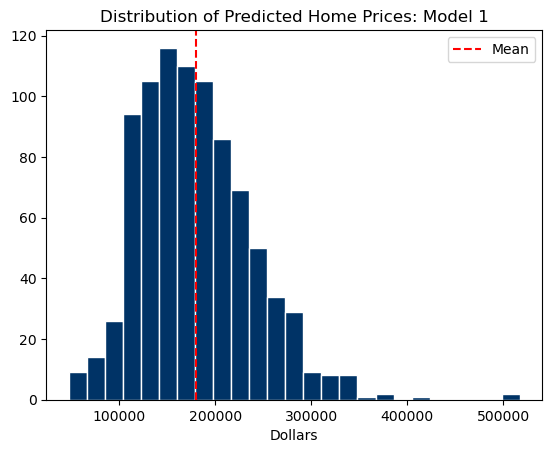

In [97]:
# check distribution

plt.hist(ulloa_kaggle_model1['SalePrice'], bins = 25,color = '#003366', edgecolor = '#ffffff')

# grab the mean from .describe() summary stats
avg = ulloa_kaggle_model1['SalePrice'].describe().values.tolist()[1]
plt.axvline(x = avg, color = '#ff0000', linestyle = '--', label = 'Mean')

plt.title('Distribution of Predicted Home Prices: Model 1')
plt.xlabel('Dollars')
plt.legend()
plt.savefig('../images/model_1_k_hist.png')

In [98]:
# save kaggle predictions file

output_path = '../datasets/clean_data/ulloa_kaggle_1.csv'
ulloa_kaggle_model1.to_csv(output_path, index = False)

---

### **Model Preprocessing and Fitting**
**Model 2**

In [100]:
# retrieve ames2 dataset

file_path = '../datasets/clean_data/ames_clean2.csv'
ames2 = pd.read_csv(file_path)

# confirm shape
ames2.shape

(2051, 83)

----
### **Create Features Matrix and Target Vector**
**Predictive Matrix**

In [102]:
features = ['indoor_area', 'garage_area', 'outdoor_area']
X = ames2[features]

# check dimensions
X.shape

(2051, 3)

---
**Target Vector**

In [104]:
y = ames2['saleprice']
y.shape

(2051,)

---
**Split Train and Test Data**

In [106]:
# use 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [107]:
# confirm shapes/dimensions

X_train.shape, X_test.shape

((1640, 3), (411, 3))

---
**Instantiate and Fit Model**

In [109]:
# instantiate
model2 = LinearRegression()

In [110]:
# fit model
model2.fit(X_train, y_train)

LinearRegression()

---
**Model Evaluation**

In [112]:
# train set R2 score
model2.score(X_train, y_train)

0.6639549010913454

In [113]:
# test set R2 score
model2.score(X_test, y_test)

0.6910132520692789

---
**Cross Validation**

In [115]:
# keep 5-fold default
cross_val_score(model2, X_train, y_train)

array([0.63287647, 0.71602755, 0.71873329, 0.43254014, 0.72287944])

In [116]:
# avg
cross_val_score(model2, X_train, y_train).mean()

0.6446113782255923

---
**Predictions and Evaluation**

In [118]:
# run predictions
predictions = model2.predict(X_test)

In [119]:
# check first five preds
predictions[:5]

array([194812.51410217, 151721.19392339, 135584.41003453, 220215.52081066,
       144921.63273452])

In [120]:
# check RMSE
rmse = round(metrics.root_mean_squared_error(y_test, predictions) , 2)
rmse

37483.47

---
### **Use Model 2 on Kaggle Data**

First, add the same calculated columns to kaggle file and save a copy.

In [123]:
# calc and add columns

# indoor area
ames_kaggle['indoor_area'] = ames_kaggle['total_bsmt_sf'] + ames_kaggle['gr_liv_area']

# outdoor area
cols = ['lot_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area']
ames_kaggle['outdoor_area'] = ames_kaggle[cols].sum(axis = 1)

In [124]:
# confirm shape and view first two rows
print(ames_kaggle.shape)
ames_kaggle.head(2)

(878, 82)


,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,indoor_area,outdoor_area
0,2658,902301120,190,RM,69.00,9142,Pave,Grvl,Reg,Lvl,...,0.0,Np,NoFe,NoFea,0.0,4,2006,WD,2948.0,9314.0
1,2718,905108090,90,RL,69.06,9662,Pave,No_Alley,IR1,Lvl,...,0.0,Np,NoFe,NoFea,0.0,8,2006,WD,3934.0,9832.0


In [125]:
# save copy
output_path = '../datasets/clean_data/kaggle_clean2.csv'

# save file
ames_kaggle.to_csv(output_path, index = False)

---
**Predictive Matrix**

In [127]:
features

['indoor_area', 'garage_area', 'outdoor_area']

In [128]:
X_kaggle = ames_kaggle[features]

X_kaggle.shape

(878, 3)

---
**Kaggle Predictions**

In [130]:
kaggle_preds = model2.predict(X_kaggle)

In [131]:
# check first 5
kaggle_preds[:5]

array([201040.22240922, 275190.85255092, 152100.37642032, 146460.17841336,
       200302.96999468])

---
**Review Kaggle Preds and Build Submission File**

In [133]:
# create DF

ulloa_kaggle_model2 = pd.DataFrame({
    'Id': ames_kaggle['id'],
    'SalePrice': kaggle_preds
})

# check dimensions
ulloa_kaggle_model2.shape

(878, 2)

In [134]:
# first 5 rows
ulloa_kaggle_model2.head()

,Id,SalePrice
0,2658,201040.222409
1,2718,275190.852551
2,2414,152100.376420
3,1989,146460.178413
4,625,200302.969995


In [135]:
# last 5 rows
ulloa_kaggle_model2.tail()

,Id,SalePrice
873,1662,207507.681942
874,1234,213788.871344
875,1373,141279.024688
876,1672,139874.048542
877,1939,130774.000302


In [136]:
# summary stats
ulloa_kaggle_model2.describe()

,SalePrice
count,878.000000
mean,180096.009919
std,62588.699678
min,30380.721606
25%,134352.711730
50%,174007.673837
75%,213761.114707
max,474222.624816


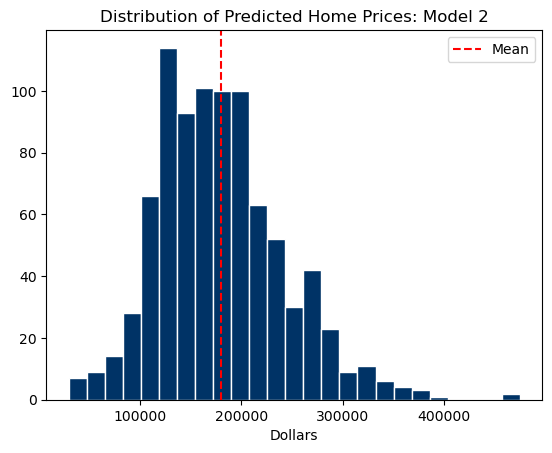

In [137]:
# check distribution

plt.hist(ulloa_kaggle_model2['SalePrice'], bins = 25, color = '#003366', edgecolor = '#ffffff')

# grab the mean from .describe() summary stats
avg = ulloa_kaggle_model2['SalePrice'].describe().values.tolist()[1]
plt.axvline(x = avg, color = '#ff0000', linestyle = '--', label = 'Mean')

plt.title('Distribution of Predicted Home Prices: Model 2')
plt.xlabel('Dollars')
plt.legend();
plt.savefig('../images/model_2_hist.png')

In [138]:
# save kaggle predictions file, model 2

output_path = '../datasets/clean_data/ulloa_kaggle_2.csv'
ulloa_kaggle_model2.to_csv(output_path, index = False)

---
**Future Model Iterations / Predictions**

Automate process here too, modify function from notebook 03.

In [261]:
def build_model(features, 
                pol = False, 
                scale = False, 
                dummy = False,
                dum_cols = None,
                df1 = ames2, 
                df2 = ames_kaggle, 
                target = 'saleprice', 
                ts = 0.75, 
                cv = 5):
    
    # X matrix ------------------------------------------------------------------
    X = df1[features]

    # target y vector -----------------------------------------------------------
    y = df1[target]


    if dummy == True:
        # create dummy vars and add to X
        X = pd.get_dummies(X, columns = [dum_cols], drop_first = True, dtype = int)
    

    # train/test split -----------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts)
    
        
    
    # poly features and scaling -------------------------------------------------
    if pol == True:
        # instantiate poly features
        poly = PolynomialFeatures(include_bias = False)
               
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
        
    if scale == True:
        # instantiate standar scaler
        sc = StandardScaler()        
        
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        

    # rest of workflow ----------------------------------------------------------
    
    # instantiate model
    lr = LinearRegression()
    
    # fit model
    lr.fit(X_train, y_train)
    
    # evaluate model
    # train set
    r2_train = round(lr.score(X_train, y_train), 2)
    # test set
    r2_test = round(lr.score(X_test, y_test), 2)
    
    # cross val
    x_val = round(cross_val_score(lr, X_train, y_train, cv = cv).mean(), 2)
    
    # metrics
    metrics = [r2_train, r2_test, x_val]
    
    # run predictions
    predictions = lr.predict(X_test)
    
    
    # Kaggle Data --------------------------------------------------------------------
    
    # X matrix
    X_kaggle = df2[features]
    
    if dummy == True:
        # create dummies
        X_kaggle = pd.get_dummies(X_kaggle, columns = [dum_cols], drop_first = True, dtype = int)
        
    if pol == True:
        # instantiate poly features
        poly = PolynomialFeatures(include_bias = False)
        X_kaggle = poly.fit_transform(X_kaggle)
    
    if scale == True:
        # instantiate standar scaler
        sc = StandardScaler()
        X_kaggle = sc.fit_transform(X_kaggle)

        
    
    # Kaggle predictions
    kaggle_preds = lr.predict(X_kaggle)
    
    # build DF
    df3 = pd.DataFrame({
        'Id': df2['id'],
        'SalePrice': kaggle_preds
    })
    
    # save DF
    output_path = '../datasets/clean_data/ulloa_kaggle_.csv'
    df3.to_csv(output_path, index = False)
    
    return metrics

In [269]:
# test function
features = ['indoor_area', 'overall_qual', 'overall_cond']
build_model(features = features, pol = True, scale = True)

[0.86, 0.78, 0.84]

The modeling function with the additional Kaggle instructions works well.

----
**Iterative Modeling**<br>
From this section on down, the model will undergo different tweaks as features are transformed, scaled, combined or dummified.  A list of features will be passed into the function and the scores will be returned for quick model evaluation.  The Kaggle submission file will be automatically generated and saved.

---
**Iteration Number 3**

In [271]:
# iteration 3, add 'year_built`
features = ['garage_area', 'indoor_area', 'outdoor_area', 'year_built']

# build/evaluate model
build_model(features = features)

[0.79, 0.69, 0.78]

On iteration number 3, the model shows a slight improvement with R2 scores above 0.6.  The model's performance is responsible for about 60% of the variability on the target variable.

----
**Iteration Number 4**

In [273]:
# iteration 4, drop 'outdoor_area'
features = ['garage_area', 'indoor_area', 'year_built']

# build/evaluate model
build_model(features = features)

[0.78, 0.65, 0.77]

Dropping the `outdoor_area` feature is not making too much of a difference.  The R2 scores are still, on average, above 0.6.  The model has not significantly improved yet.

----
**Iteration Number 5**<br>
Based on EDA findings on notebook number 2, and model testing on notebook 3, this fifth iteration combines two columns to create an interactive term.  It also adds two columns that measure area together.

In [275]:
# iteration 5

# Interactive terms
ames2['overall qual * cond'] = ames2['overall_qual'] * ames2['overall_cond']
ames_kaggle['overall qual * cond'] = ames_kaggle['overall_qual'] * ames_kaggle['overall_cond']

# Combine garage and indoor for total house area
ames2['total_house_area'] = ames2['garage_area'] + ames2['indoor_area']
ames_kaggle['total_house_area'] = ames_kaggle['garage_area'] + ames_kaggle['indoor_area']

In [277]:
# iteration 5
features = ['total_house_area', 'year_built', 'overall qual * cond']

# build/evaluate model
build_model(features = features)

[0.69, 0.78, 0.69]

Much better performance.  Good for a submission to Kaggle.

---
**Iteration Number 6**<br>
Based on additional EDA and model testing and tweaking on notebook 3, this iteration will consist of polynomial features and scaling.  Full bathrooms and half bathrooms will be combined into new columns.

In [279]:
# iteration 6
# use poly features and scale vars

# combine full baths into one col
ames2['full_baths'] = ames2['bsmt_full_bath'] + ames2['full_bath']
ames_kaggle['full_baths'] = ames_kaggle['bsmt_full_bath'] + ames_kaggle['full_bath']

# combine 1/2 baths into one col
ames2['half_baths'] = ames2['bsmt_half_bath'] + ames2['half_bath']
ames_kaggle['half_baths'] = ames_kaggle['bsmt_half_bath'] + ames_kaggle['half_bath']

# drop 'overall qual * cond' col, poly feat taking care of it
ames2.drop(columns = 'overall qual * cond', inplace = True)
ames_kaggle.drop(columns = 'overall qual * cond', inplace = True)

Test model, below.

In [281]:
# build/eval model
features = ['year_built', 'total_house_area', 'overall_qual', 'overall_cond', 'full_baths', 'half_baths']
build_model(features = features, pol = True, scale = True)

[0.89, 0.87, 0.45]

The training set is doing quite well, the test set is fluctuating a bit.  These are signs the model may be a bit overfitted.

---
**Iteration Number 7**<br>
Besides current features, this iteration will also take into account the month when the home was sold, the total number of rooms, fireplaces and whether centrail AC is available or not.  This last variable will be dummified. Polynonial features and scaling will also be used.

In [299]:
# test function
features = ['total_house_area', 'overall_qual', 'overall_cond', 'mo_sold',
            'full_baths', 'half_baths', 'totrms_abvgrd', 'fireplaces', 'central_air']
build_model(features = features, pol = True, scale = True, dummy = True, dum_cols = 'central_air')

[0.9, 0.84, 0.87]

The R2 score on the the training set is quite strong, the test set fluctuates somewhat.  Again, signs that overfitting needs to be addressed in order to get the right bias/variance balance.